In [1]:
import os
import sys
import importlib
import moten
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

print(sys.path)
%pwd

os.chdir('/home/rfpred')
sys.path.append('/home/rfpred/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/')
sys.path.append('/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsdcode')

from classes.voxelsieve import VoxelSieve
from classes.natspatpred import NatSpatPred
NSP = NatSpatPred()
NSP.initialise()

# file_exists = os.path.isfile(f"{NSP.own_datapath}/visfeats/gabor_pyramid/gauss_checker_output.npy")


from funcs.reloads import Reloader

import importlib
import classes.utilities
from classes.utilities import Utilities

importlib.reload(classes.utilities)
from classes.utilities import Utilities

rl = Reloader()
NSP = rl.nsp()

import funcs.gaborpyr
importlib.reload(funcs.gaborpyr)
import funcs.gaborpyr

['/home/rfpred/notebooks/construction_work', '/home/rfpred/envs/rfenv/lib/python311.zip', '/home/rfpred/envs/rfenv/lib/python3.11', '/home/rfpred/envs/rfenv/lib/python3.11/lib-dynload', '', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages', '/home/rfpred/notebooks/alien_nbs/lgnpy', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/nsd_access-0.0.1.dev0-py3.11.egg', '/home/rfpred/envs/rfenv/lib/python3.11/site-packages/cifti-1.1-py3.11.egg']
Naturalistic Spatial Prediction class: Initialised

Class contains the following attributes:
 .analyse
 .attributes
 .cortex
 .datafetch
 .explore
 .hidden_methods
 .initialise
 .nsd_datapath
 .own_datapath
 .stimuli
 .subjects
 .utils


In [2]:
from funcs.gaborpyr import (
    isotropic_gaussian,
    circle_stim,
    random_dot,
    show,
    cut_corners,
    make_checker,
    plot_filter_locations,
    plot_filter_outputs,
    normalize_output,
    select_filters,
    cut_paste_mask,
    location_based_selection,
    filts_per_freq,
    orient_boolmask,
    gab_heatmap,
)

# Optimisation of gabor filter selection


### Create a stimulus that represents the visual region of which we want to quantify the content. To this end we'll convolve a nested checker stimulus with an isotropic gaussian.


In [3]:
subject = "subj01"
pixels = 425
degrees = 8.4
pix_per_deg = pixels / degrees

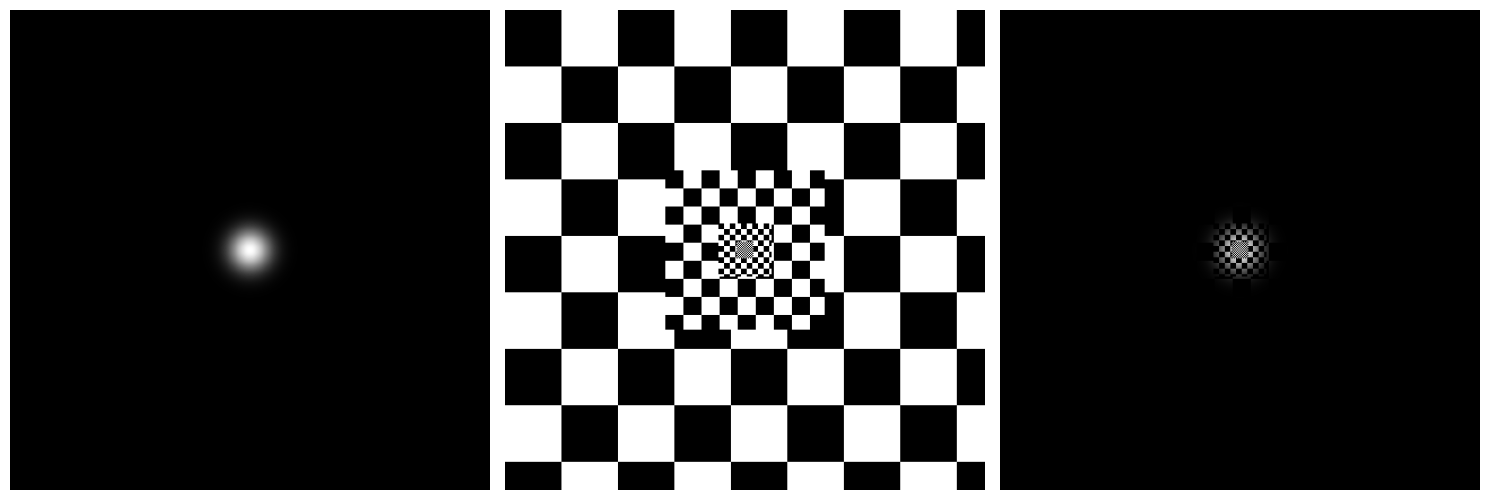

In [4]:
gauss = isotropic_gaussian(
    dims=(425, 425), sigma=pix_per_deg / 4
)  # Justify this 2.5 factor

checker_stim = make_checker(
    dims=(425, 425),
    checkercenter=(212, 212),
    scales=3,
    scaling_factor=3,
    checker_size=50,
    stride=0,
)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for img_no, img in enumerate([gauss, checker_stim, checker_stim * gauss]):
    axes[img_no].imshow(img, cmap="gist_gray")
    axes[img_no].axis("off")
plt.tight_layout()

gauss_check_stack = np.stack([gauss, checker_stim * gauss], axis=0)

### Here we build our gabor filter pyramid given a set of defined parameters.


In [ ]:
# The pymoten standard values:
    # def __init__(self,
    #              stimulus_vhsize=(576, 1024),
    #              stimulus_fps=24,
    #              temporal_frequencies=[0,2,4],
    #              spatial_frequencies=[0,2,4,8,16],
    #              spatial_directions=[0,45,90,135,180,225,270,315],
    #              sf_gauss_ratio=0.6,
    #              max_spatial_env=0.3,
    #              filter_spacing=3.5,
    #              tf_gauss_ratio=10.,
    #              max_temp_env=0.3,
    #              include_edges=False,
    #              spatial_phase_offset=0.0,
    #              filter_temporal_width='auto'):

In [5]:
#### THE ONE THAT I'M RUNNING FOR RIGHT NOW!!!!!! DON'T DELETE #####

# # Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# # If I want to transform this to cycles per degree, I need to divide by 8.4
# pyr_pars = {
#     "spatial_frequencies": [4.2, 8.4, 16.8, 33.6,],  # 1, 2, 4, 8 cycles per degree (octave)
#     "spatial_orientations": tuple(range(0, 180, 30)),  # 0, 45, 90, 135
#     "sf_gauss_ratio": 1.5, #(1/np.pi), # was .25,  # ratio of spatial frequency to gaussian s.d.
#     "max_spatial_env": .75 / 8.4,  # max sd of gaussian envelope
#     "filter_spacing": 1,  # filter spacing in degrees
#     "spatial_phase_offset": 0,  # spatial phase offset in degrees
# }

# checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(
#     stimulus=gauss_check_stack, **pyr_pars
# )

# checkpyramid.view.nfilters





# Original spatfreqs = [0.25, 0.5, 1, 2] in cycles per image (so cycles per 8.4 degrees)
# If I want to transform this to cycles per degree, I need to divide by 8.4
pyr_pars = {
    "spatial_frequencies": [4.2, 8.4, 16.8, 33.6,],  # 1, 2, 4, 8 cycles per degree (octave)
    "spatial_orientations": tuple(range(0, 180, 45)),  # 0, 45, 90, 135
    "sf_gauss_ratio": .45 ,#(1/np.pi), # was .25,  # ratio of spatial frequency to gaussian s.d.
    "max_spatial_env": .5/8.4, # / 8.4,  # max sd of gaussian envelope
    "filter_spacing": 1,  # filter spacing in degrees
    "spatial_phase_offset": 0,  # spatial phase offset in degrees
}

checkpyramid = moten.pyramids.StimulusStaticGaborPyramid(
    stimulus=gauss_check_stack, **pyr_pars
)

checkpyramid.view.nfilters

28848

In [6]:
2/8.4
1/np.pi

0.3183098861837907

### I'll try to filter out the filters that fall outside the patch region beforehand to reduce computational costs (time mostly)


[0.3811764705882353, 0.6164705882352941, 0.3811764705882353, 0.6164705882352941]


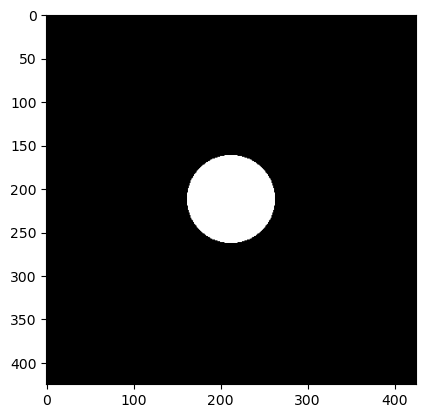

In [7]:
circ, bounds_prc = NSP.utils.boolmask(
    pix_dims=425,
    deg_dims=8.4,
    eccentricity=0,
    angle=0,
    radius=1,
    plot=True,
    return_bounds=True,
    bound_units="prc",
)

print(bounds_prc)


### Select only those gabor filters that fall within the patch region

In [724]:
filts_in_patch, filts_boolvec = location_based_selection(checkpyramid, bounds_prc, verbose=True)

Original number of filters: 28848
Number of filters encapsulated by our patch: 1616


### Project the gaussian checkerboard stimulus to be processed by the selection of filters

In [725]:
# Project the stimulus onto the filters that fall inside the patch region
gauss_output = checkpyramid.project_stimulus(gauss_check_stack, filters=filts_in_patch)

project_stimulus: 100%|██████████| 1616/1616 [00:21<00:00, 73.96it/s]


### Check how many filters each spatial frequency contains

In [726]:
filters_per_freq = filts_per_freq(pyr_pars, filts_in_patch)
print(filters_per_freq)

[36, 100, 324, 1156]


### Inspect the spatial frequency specific filter outputs for the gaussian checkerboard stimulus

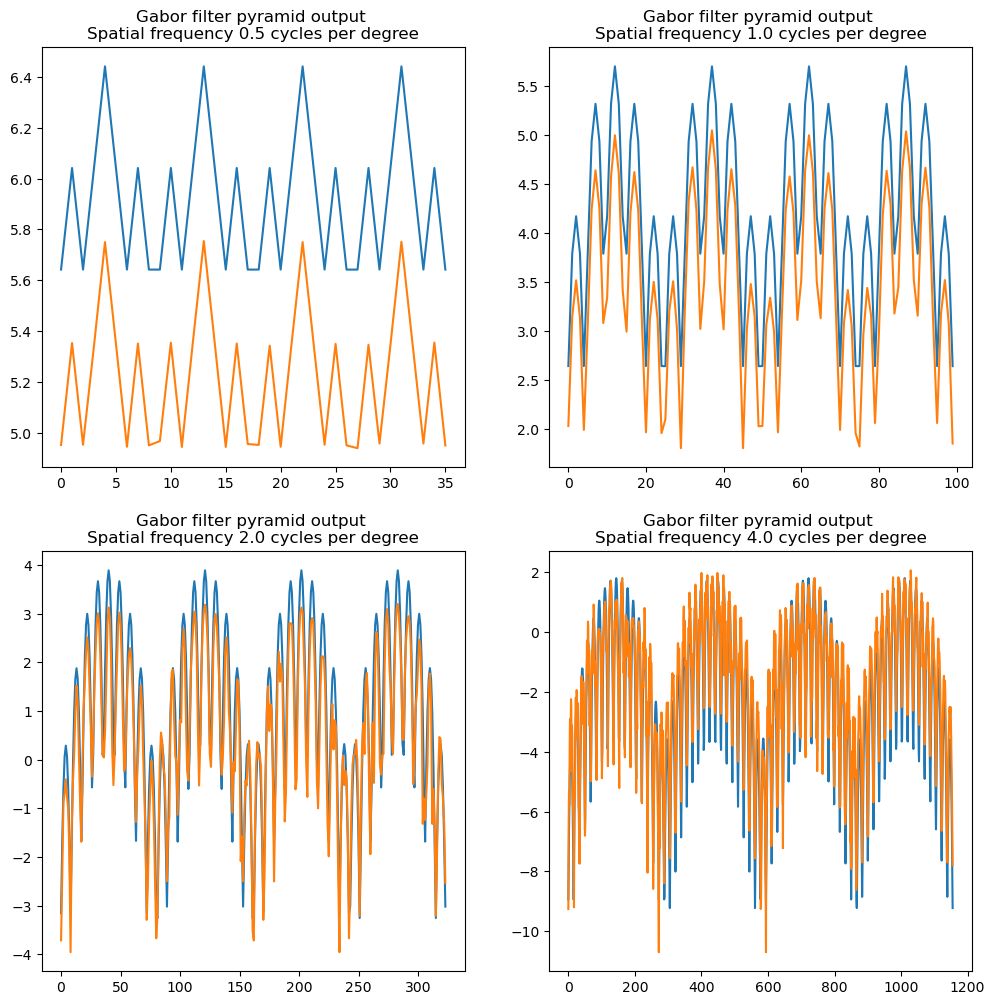

In [727]:
plot_filter_outputs(
    sel_output=gauss_output,
    filters_per_freq_sel=filters_per_freq,
    spat_freqs=pyr_pars["spatial_frequencies"],
    img_indices=[0, 1],
)

### Get a boolean mask for every separate gabor filter orientation

In [728]:
orient_mask = orient_boolmask(filts_in_patch)
orient_mask

array([[ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True]])

In [739]:
output_norm, filters_per_freq_sel, filter_selection, filter_selection_dictlist = (
    select_filters(
        pyramid=checkpyramid,
        filter_list=filts_in_patch,
        output=gauss_output,
        imgs=gauss_check_stack,
        img_no=1,
        spat_freqs=pyr_pars["spatial_frequencies"],
        direction_masks=orient_mask,
        filters_per_freq=filters_per_freq,
        percentile_cutoff=99.5,  # Het moet maar
        best_n=None,
        verbose=True,
    )
)
# Stack the directions
full_filter = np.sum(np.array(filter_selection), axis=0)

# The indices for the filters that are within the patch
filter_indices = np.where(full_filter == True)[0]

Direction 0, Spatial frequency 0: number of values > percentile = 1
Direction 0, Spatial frequency 1: number of values > percentile = 1
Direction 0, Spatial frequency 2: number of values > percentile = 2
Direction 0, Spatial frequency 3: number of values > percentile = 6
Direction 1, Spatial frequency 0: number of values > percentile = 1
Direction 1, Spatial frequency 1: number of values > percentile = 1
Direction 1, Spatial frequency 2: number of values > percentile = 1
Direction 1, Spatial frequency 3: number of values > percentile = 6
Direction 2, Spatial frequency 0: number of values > percentile = 1
Direction 2, Spatial frequency 1: number of values > percentile = 1
Direction 2, Spatial frequency 2: number of values > percentile = 2
Direction 2, Spatial frequency 3: number of values > percentile = 6
Direction 3, Spatial frequency 0: number of values > percentile = 1
Direction 3, Spatial frequency 1: number of values > percentile = 1
Direction 3, Spatial frequency 2: number of valu

In [740]:
print(f"Total amount of filters: {np.sum(full_filter)}")

Total amount of filters: 37


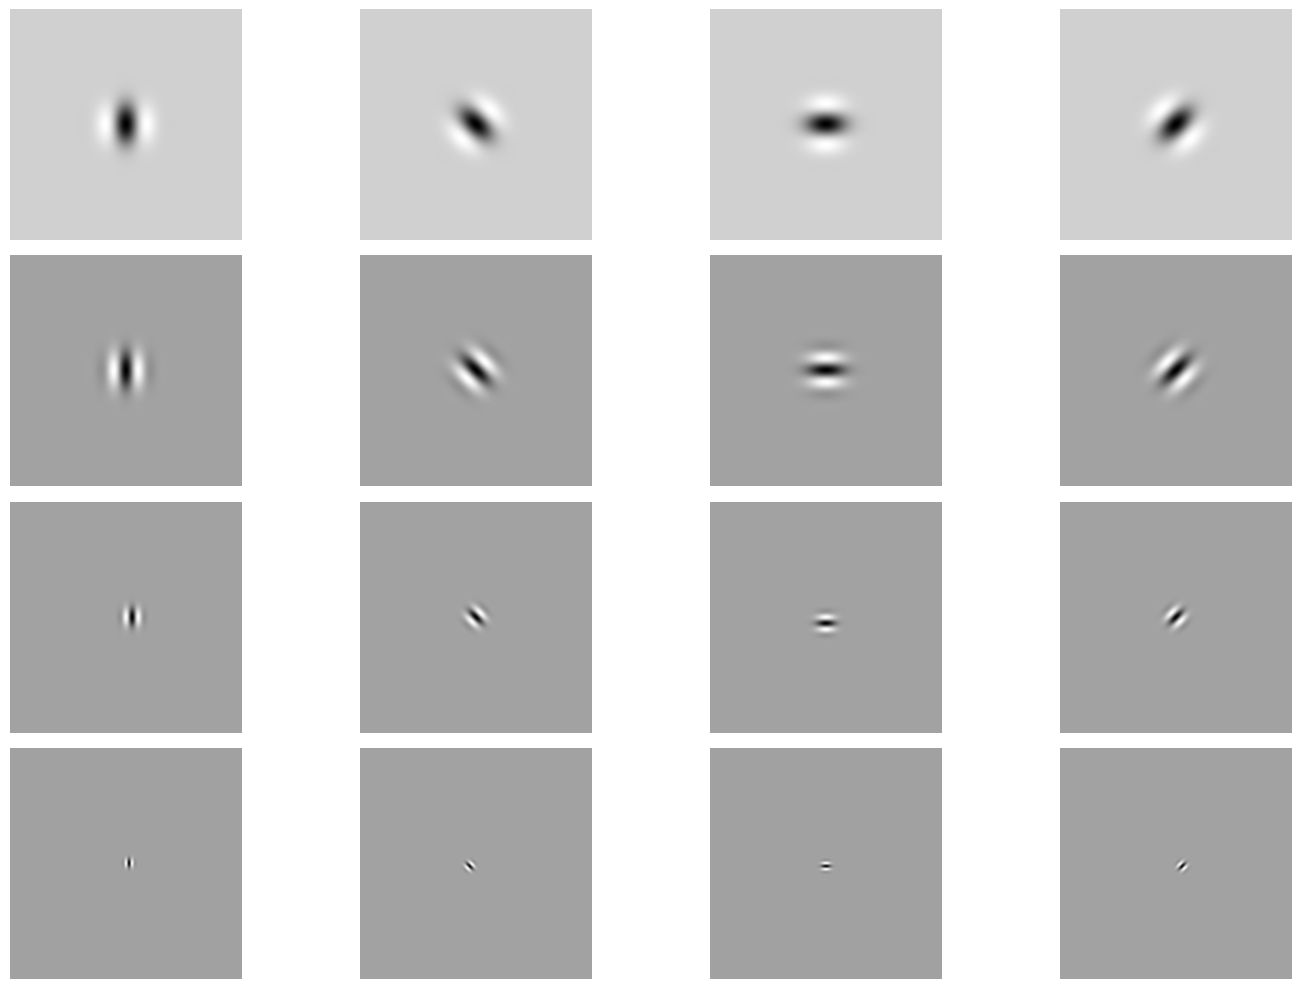

In [741]:
n_spatfreqs = len(pyr_pars["spatial_frequencies"])
n_dirs = len(pyr_pars["spatial_orientations"])
fig, axs = plt.subplots(n_dirs, n_spatfreqs, figsize=(15, 10))  # Adjust the figure size as needed

for i in range(n_spatfreqs):
    for j in range(n_dirs):
        heat_ar = gab_heatmap(
            filter_selection_dictlist,
            filts_per_freq=filters_per_freq_sel,
            dir_idx=i,  # int or "all"
            freq_idx=j,  # int or "all"
            cmap="gray",
            single_filter=True,
            plot=False,
        )

        # Squeeze out the first dimension of heat_ar
        heat_ar = np.squeeze(heat_ar)

        axs[j, i].imshow(heat_ar, cmap='binary')  # Display the heatmap on the j-th row and i-th column subplot
        axs[j, i].axis("off")

plt.tight_layout()
plt.show()

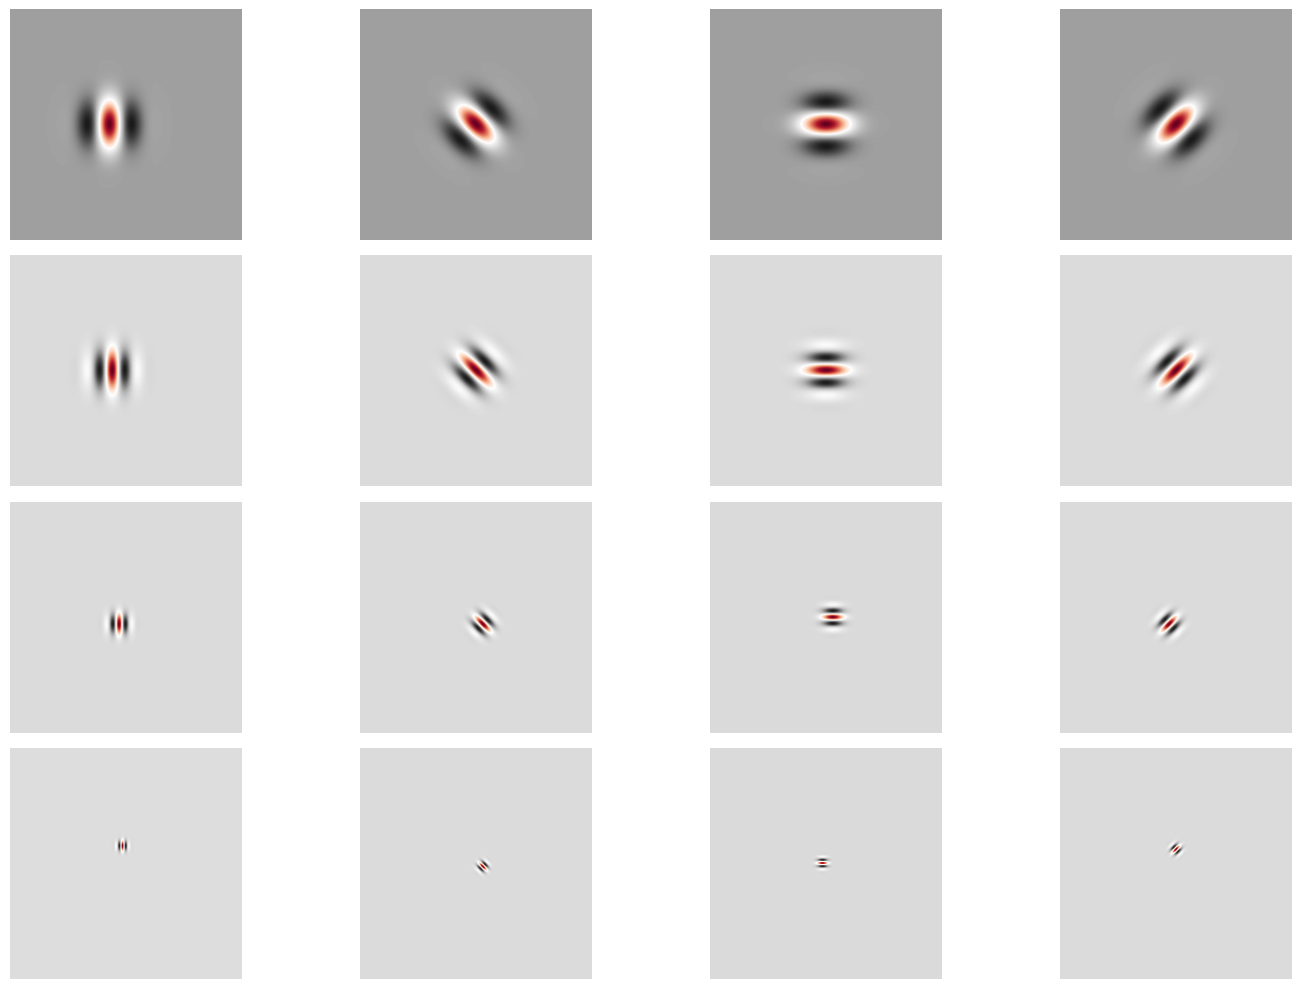

In [483]:
n_spatfreqs = len(pyr_pars["spatial_frequencies"])
n_dirs = len(pyr_pars["spatial_orientations"])
fig, axs = plt.subplots(n_dirs, n_spatfreqs, figsize=(15, 10))  # Adjust the figure size as needed

for i in range(n_spatfreqs):
    for j in range(n_dirs):
        heat_ar = gab_heatmap(
            filter_selection_dictlist,
            filts_per_freq=filters_per_freq_sel,
            dir_idx=i,  # int or "all"
            freq_idx=j,  # int or "all"
            cmap="gray",
            single_filter=True,
            plot=False,
        )

        # Squeeze out the first dimension of heat_ar
        heat_ar = np.squeeze(heat_ar)

        axs[j, i].imshow(heat_ar, cmap='RdGy_r')  # Display the heatmap on the j-th row and i-th column subplot
        axs[j, i].axis("off")

plt.tight_layout()
plt.show()

### Visualise the gabor filters to inspect whether we have made a sensible selection for our current patch

In [ ]:
for i in range(6):
    heat_ar = gab_heatmap(
        filter_selection_dictlist,
        filts_per_freq=filters_per_freq_sel,
        dir_idx=i, # int or "all"
        freq_idx=0, # int or "all"
        cmap="gray",
        single_filter=False
    )

    plt.axis("off")

### This function is not super useful anymore as it relies on a boolean vector that is based on the original pyramid filter size, but as we already do a location based preselection, this becomes cumbersome. 

Luckily we can also use the dictionary information as input to view a filter

In [ ]:
filt_no = 10
for this_orient in range(len(filter_selection)):
    checkpyramid.view.show_filter(filter_selection_dictlist[this_orient][filt_no])
    plt.show()

### Project this gabor selection through a number of stimuli for subj01

### Load in the images from the NSD

In [16]:
subject = "subj01"
which_cnn = "vggfull"

In [9]:
dmx = NSP.stimuli.imgs_designmx()[subject]

In [748]:
from skimage import color

start_img = 0
end_img = 500

# FOR NOW I DEFINE THE SUBJECT BECAUSE I WANT TO CHECK THE PERFORMANCE
# OF THE MODEL BEFORE COMPUTING IT FOR THE 73K IMAGES
imgs,_ = NSP.stimuli.rand_img_list(n_imgs=(end_img-start_img), 
                                   asPIL=False, 
                                   add_masks=False, 
                                   select_ices=dmx[start_img:end_img],)

img_list = []

print("Converting images to luminance channel")
for img_no, img in enumerate(imgs):

    # Convert RGB image to LAB colour space
    lab_image = color.rgb2lab(imgs[img_no])

    # First channel [0] is Luminance, second [1] is green-red, third [2] is blue-yellow
    lumimg = lab_image[
        :, :, 0
    ]  # Extract the L channel for luminance values, assign to input array

    img_list.append(lumimg)

imgstack = np.array(img_list)

Converting images to luminance channel


In [749]:
# flatten the list of filter dicts over directions
flat_list = [item for sublist in filter_selection_dictlist for item in sublist]

# project the stimuli onto the filters
nsd_output = checkpyramid.project_stimulus(imgstack, filters=flat_list) 

project_stimulus: 100%|██████████| 37/37 [00:01<00:00, 27.87it/s]


In [750]:
# Aggregate the filters per frequency across orientations
filters_per_freq_agg = np.sum(filters_per_freq_sel, axis=0)

# Normalise the output for each spatial frequency separately
nsd_output_norm = normalize_output(nsd_output, len(pyr_pars["spatial_frequencies"]), filters_per_freq_agg) 

### Continue with the analyses

In [17]:
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

############ CONSTRAINED VOXEL SELECTION Y-MATRIX ################
##### ALSO RUN THIS FOR THE PRED FEATS SEPARATELY WITHOUT THE BASELINE #########

# subject = "subj03"
max_size = 1
min_size = .15
# min_size = args.min_prfsize if args.min_prfsize is not None else .15 # This is for the robustness analyses
patchbound = 1
# patchbound = args.patch_radius if args.patch_radius is not None else 1
min_nsd_R2 = 0
min_prf_R2 = 0
# fixed_n_voxels = 170

voxeldict = {}
n_voxels = []
for roi in rois:
    print_attr = True if roi == rois[len(rois)-1] else False
    voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                subject=subject, 
                                roi=roi,
                                patchloc='central', 
                                # patchloc='peripheral', 
                                max_size=max_size, 
                                min_size=min_size, 
                                patchbound=patchbound, 
                                min_nsd_R2=min_nsd_R2, 
                                min_prf_R2=min_prf_R2,
                                print_attributes=print_attr,
                                fixed_n_voxels=None,
                                # peri_angle=210,
                                # peri_ecc=2.0,
                                # leniency = .5
                                )
    n_voxels.append(len(voxeldict[roi].size))
    
max_n_voxels = np.min(n_voxels)

ydict = {}
for roi in rois:
    # ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=end_img-start_img).T # I changed n_trials
    ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=30000).T # I changed n_trials
    print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')


V1 voxels that fulfill requirements: 437 out of 7887.
V2 voxels that fulfill requirements: 805 out of 8296.
V3 voxels that fulfill requirements: 746 out of 7022.
V4 voxels that fulfill requirements: 538 out of 3976.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 437)
V2 y-matrix has dimensions: (30000, 805)
V3 y-matrix has dimensions: (30000, 746)
V4 y-matrix has dimensions: (30000, 538)


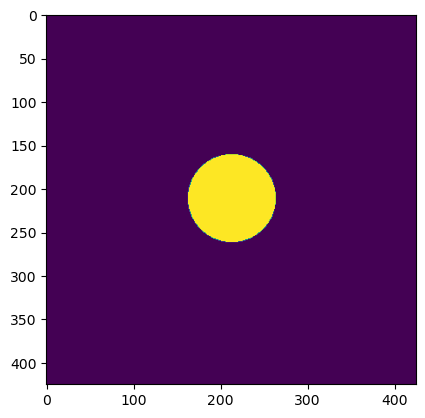

In [13]:
plt.imshow(voxeldict["V1"].patchmask)

In [752]:
Xpred_conv = NSP.stimuli.unpred_feats(
    cnn_type=which_cnn,
    content=True,
    style=False,
    ssim=False,
    pixel_loss=False,
    L1=False,
    MSE=True,
    verbose=True,
    outlier_sd_bound=5,
    subject=subject,
    # peripheral=True,
    # peri_ecc=2.0,
    # peri_angle=210,
)[: ydict["V1"].shape[0]]

Xpred_dense = NSP.stimuli.unpred_feats(
    cnn_type=which_cnn,
    content=True,
    style=False,
    ssim=False,
    pixel_loss=False,
    L1=False,
    MSE=True,
    verbose=True,
    outlier_sd_bound=5,
    subject=subject,
    dense=True,
    # peripheral=True,
    # peri_ecc=2.0,
    # peri_angle=210,
)[: ydict["V1"].shape[0]]

Xpred = np.hstack((Xpred_conv, Xpred_dense))
Xpred.shape

Fetched file from: all_predestims_vggfull.csv
['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE', 'content_loss_3_MSE', 'content_loss_4_MSE', 'content_loss_5_MSE', 'content_loss_6_MSE', 'content_loss_7_MSE', 'content_loss_8_MSE', 'content_loss_9_MSE', 'content_loss_10_MSE', 'content_loss_11_MSE', 'content_loss_12_MSE', 'content_loss_13_MSE']
Fetched file from: all_predestims_vggfull.csv
['content_loss_0_MSE', 'content_loss_1_MSE', 'content_loss_2_MSE']


(500, 17)

### This is to get the delta r w.r.t. shuffled model for the raw baseline performance of gabor pyramid 

In [19]:
from scipy.stats import zscore as zs
Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir4_loc_optimal', verbose=False)
Xbl = zs(Xgabor_sub[: ydict["V1"].shape[0]])

### This is for the encoding featmap baseline alternative to see how it performance compared to shuffled model

In [31]:

# Already zscored
Xbl = NSP.stimuli.alex_featmaps([7], subject, plot_corrmx=False, smallpatch=True, modeltype="VGG")[:ydict["V1"].shape[0]]


In [23]:
# Prepare the data for the ridg reg model
Xbl = nsd_output_norm
Xpred = Xpred[:Xbl.shape[0], :]
print(Xpred.shape)
print(Xbl.shape)

NameError: name 'nsd_output_norm' is not defined

In [736]:
Xpred_mean = np.mean(Xpred, axis=1).reshape(-1,1)
Xpred_mean.shape

# Xpred = Xpred_mean

(500, 1)

V1 voxels that fulfill requirements: 7887 out of 7887.
V2 voxels that fulfill requirements: 8296 out of 8296.
V3 voxels that fulfill requirements: 7022 out of 7022.
V4 voxels that fulfill requirements: 3976 out of 3976.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 7887)
V2 y-matrix has dimensions: (30000, 8296)
V3 y-matrix has dimensions: (30000, 7022)
V4 y-matrix has dimensions: (30000, 3976)
Running the analysis for subj01
X has these dimensions: (30000, 500)


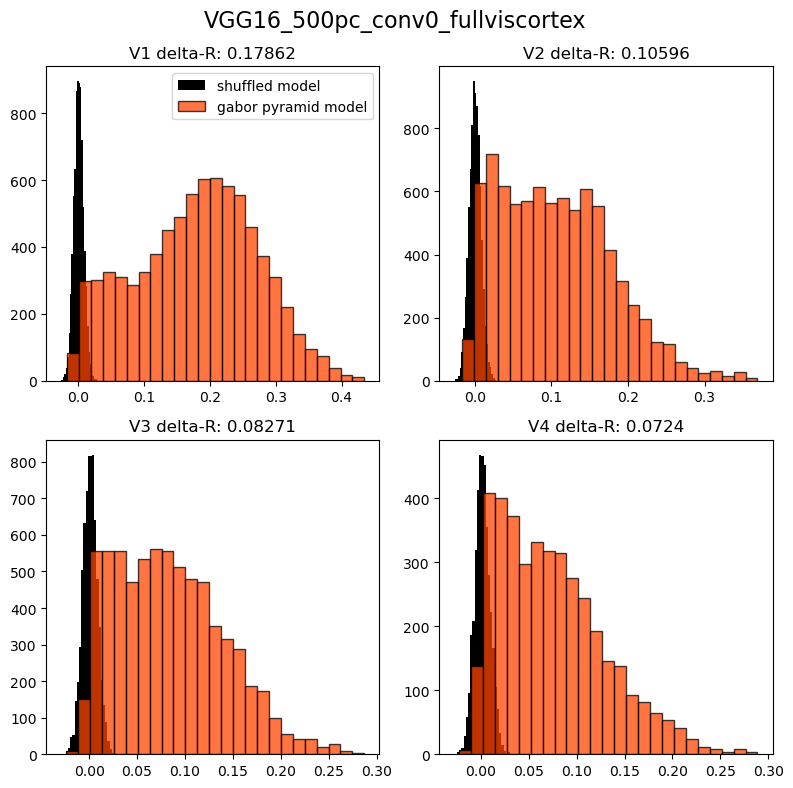

V1 voxels that fulfill requirements: 6476 out of 6476.
V2 voxels that fulfill requirements: 6376 out of 6376.
V3 voxels that fulfill requirements: 6236 out of 6236.
V4 voxels that fulfill requirements: 2887 out of 2887.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 6476)
V2 y-matrix has dimensions: (30000, 6376)
V3 y-matrix has dimensions: (30000, 6236)
V4 y-matrix has dimensions: (30000, 2887)
Running the analysis for subj02
X has these dimensions: (30000, 500)


<Figure size 640x480 with 0 Axes>

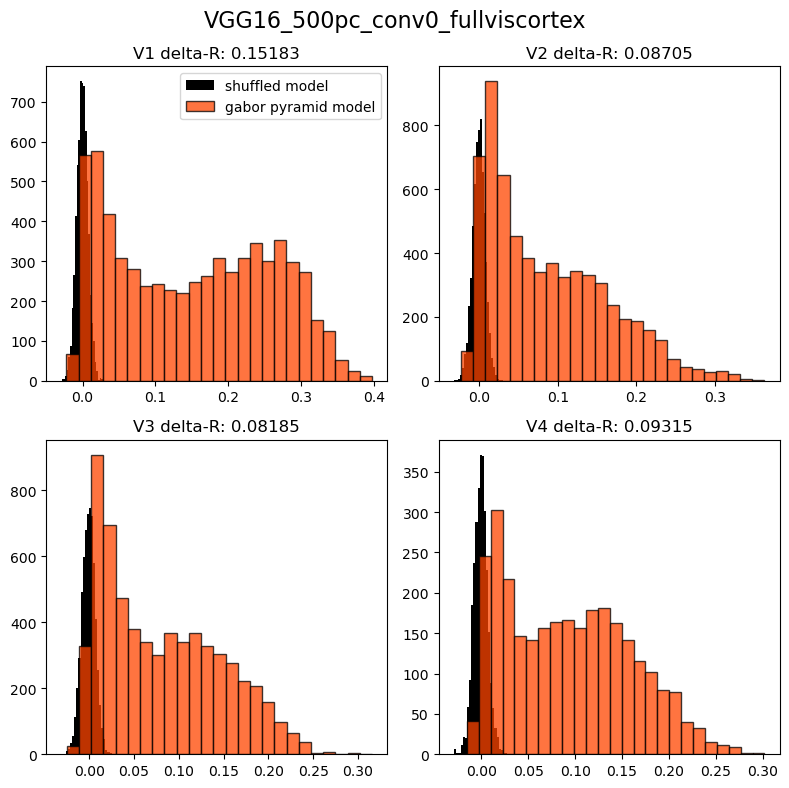

V1 voxels that fulfill requirements: 7358 out of 7358.
V2 voxels that fulfill requirements: 6721 out of 6721.
V3 voxels that fulfill requirements: 5316 out of 5316.
V4 voxels that fulfill requirements: 2486 out of 2486.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (24000, 7358)
V2 y-matrix has dimensions: (24000, 6721)
V3 y-matrix has dimensions: (24000, 5316)
V4 y-matrix has dimensions: (24000, 2486)
Running the analysis for subj03
X has these dimensions: (24000, 500)


<Figure size 640x480 with 0 Axes>

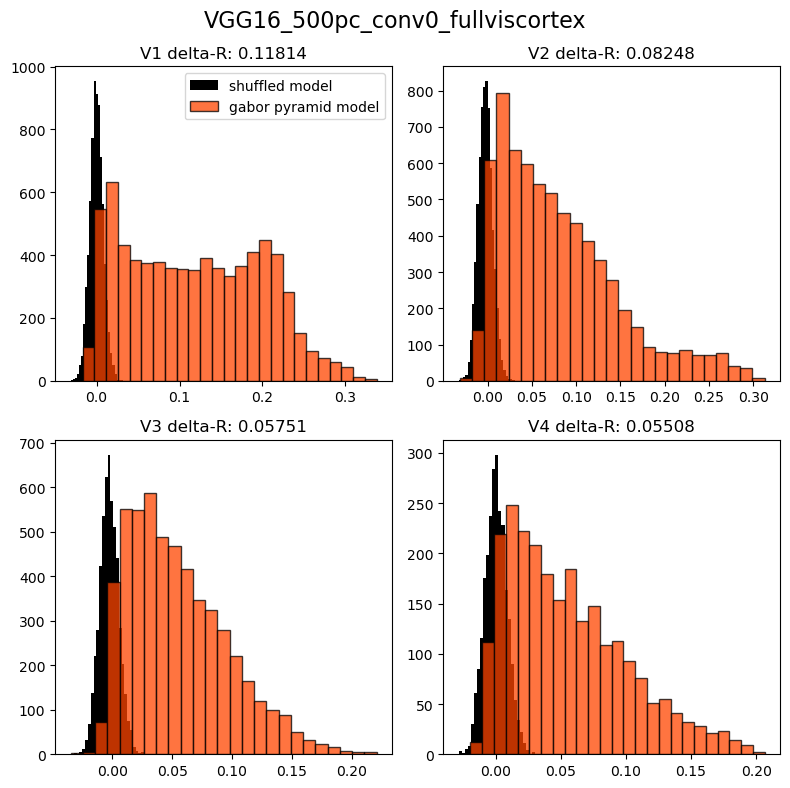

V1 voxels that fulfill requirements: 5119 out of 5119.
V2 voxels that fulfill requirements: 5088 out of 5088.
V3 voxels that fulfill requirements: 4669 out of 4669.
V4 voxels that fulfill requirements: 2790 out of 2790.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (22500, 5119)
V2 y-matrix has dimensions: (22500, 5088)
V3 y-matrix has dimensions: (22500, 4669)
V4 y-matrix has dimensions: (22500, 2790)
Running the analysis for subj04
X has these dimensions: (22500, 500)


<Figure size 640x480 with 0 Axes>

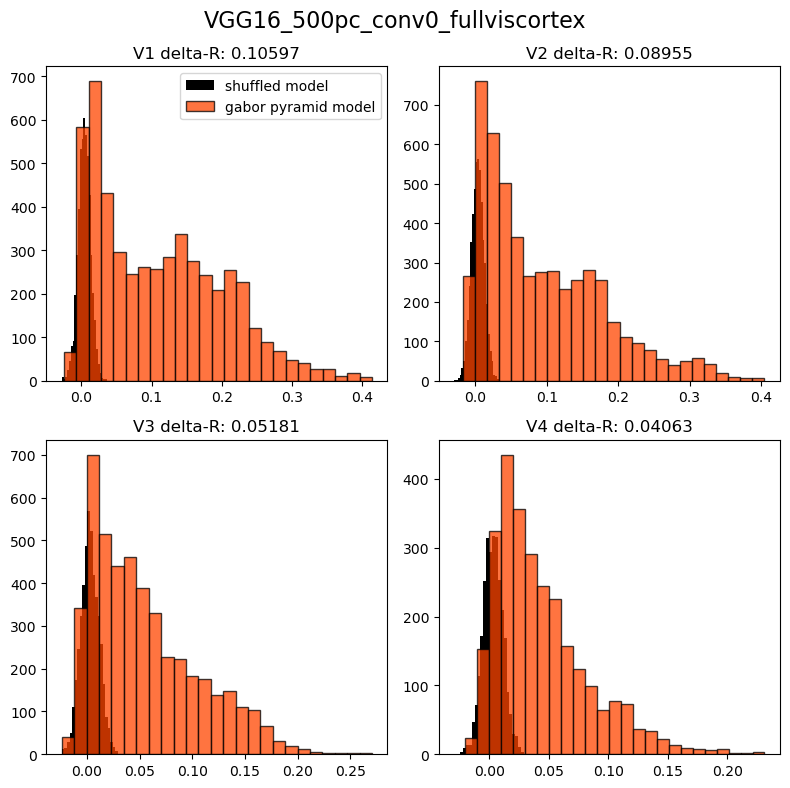

V1 voxels that fulfill requirements: 6502 out of 6502.
V2 voxels that fulfill requirements: 6309 out of 6309.
V3 voxels that fulfill requirements: 5383 out of 5383.
V4 voxels that fulfill requirements: 3184 out of 3184.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 6502)
V2 y-matrix has dimensions: (30000, 6309)
V3 y-matrix has dimensions: (30000, 5383)
V4 y-matrix has dimensions: (30000, 3184)
Running the analysis for subj05
X has these dimensions: (30000, 500)


<Figure size 640x480 with 0 Axes>

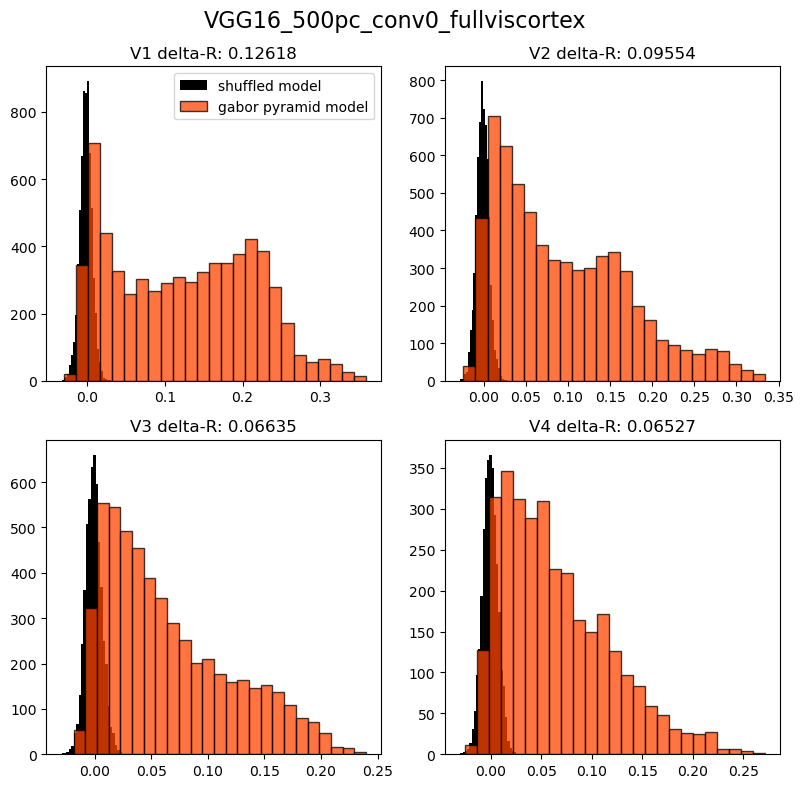

V1 voxels that fulfill requirements: 6479 out of 6479.
V2 voxels that fulfill requirements: 6905 out of 6905.
V3 voxels that fulfill requirements: 7130 out of 7130.
V4 voxels that fulfill requirements: 2846 out of 2846.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (24000, 6479)
V2 y-matrix has dimensions: (24000, 6905)
V3 y-matrix has dimensions: (24000, 7130)
V4 y-matrix has dimensions: (24000, 2846)
Running the analysis for subj06
X has these dimensions: (24000, 500)


<Figure size 640x480 with 0 Axes>

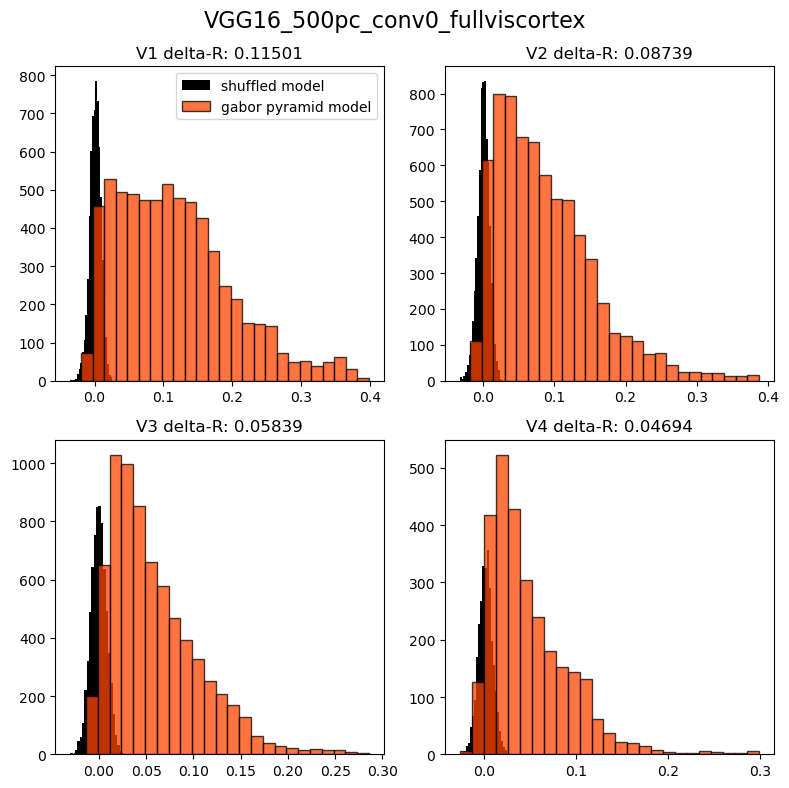

V1 voxels that fulfill requirements: 6663 out of 6663.
V2 voxels that fulfill requirements: 5589 out of 5589.
V3 voxels that fulfill requirements: 4213 out of 4213.
V4 voxels that fulfill requirements: 2286 out of 2286.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (30000, 6663)
V2 y-matrix has dimensions: (30000, 5589)
V3 y-matrix has dimensions: (30000, 4213)
V4 y-matrix has dimensions: (30000, 2286)
Running the analysis for subj07
X has these dimensions: (30000, 500)


<Figure size 640x480 with 0 Axes>

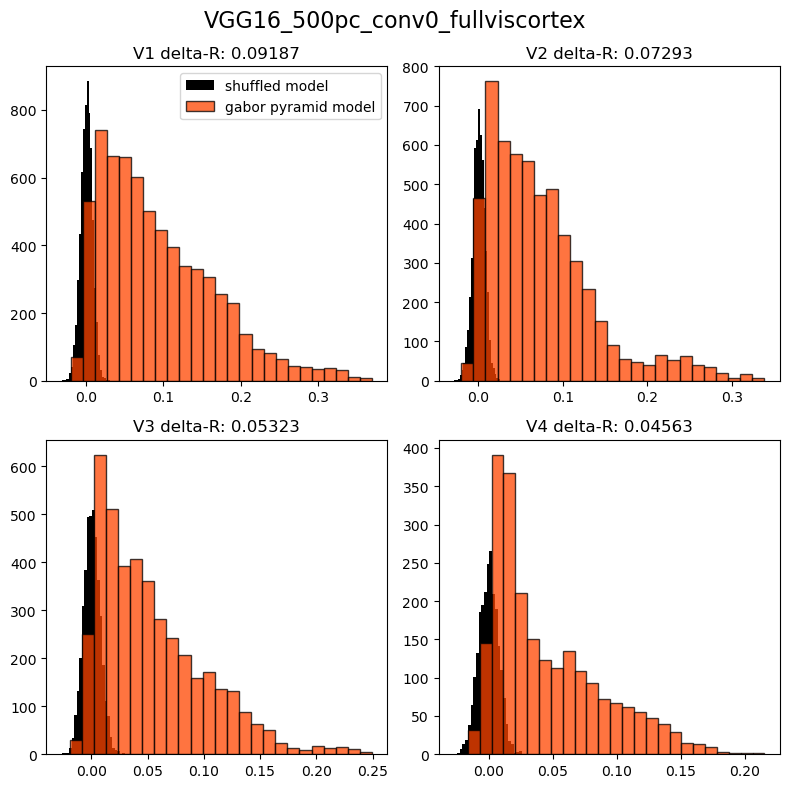

V1 voxels that fulfill requirements: 6188 out of 6188.
V2 voxels that fulfill requirements: 6003 out of 6003.
V3 voxels that fulfill requirements: 5159 out of 5159.
V4 voxels that fulfill requirements: 2845 out of 2845.

Class contains the following attributes:
 .angle
 .ecc
 .figdims
 .nsd_R2
 .patchbound
 .patchcoords
 .patchmask
 .prf_R2
 .sigmas
 .size
 .vox_lim
 .vox_pick
 .xcoor
 .xyz
 .ycoor


V1 y-matrix has dimensions: (22500, 6188)
V2 y-matrix has dimensions: (22500, 6003)
V3 y-matrix has dimensions: (22500, 5159)
V4 y-matrix has dimensions: (22500, 2845)
Running the analysis for subj08
X has these dimensions: (22500, 500)


<Figure size 640x480 with 0 Axes>

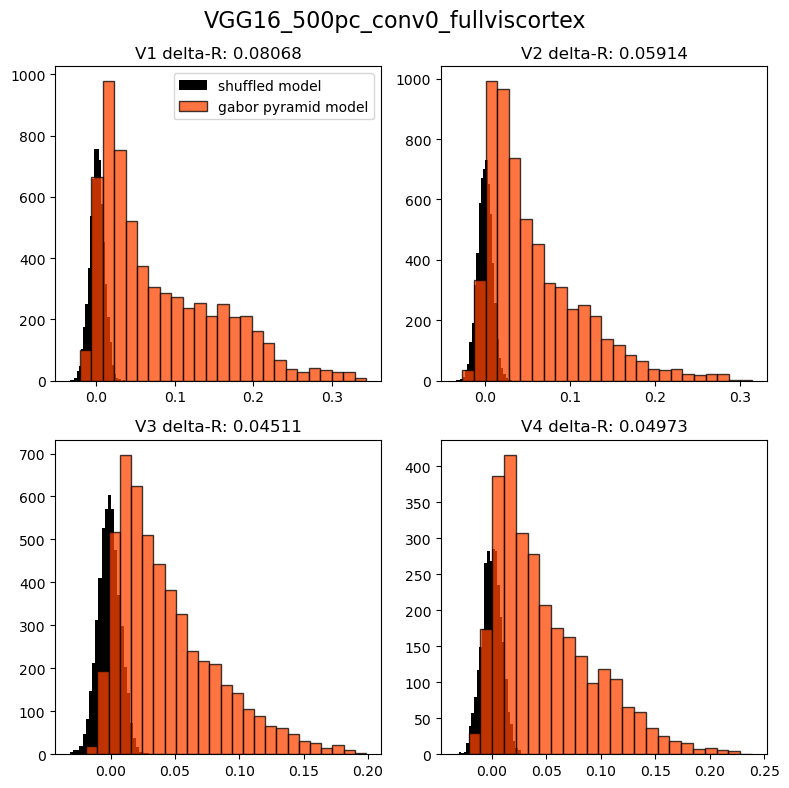

<Figure size 640x480 with 0 Axes>

In [44]:
from scipy.stats import zscore as zs
rois, roi_masks, viscortex_mask = NSP.cortex.visrois_dict(verbose=False)
prf_dict = NSP.cortex.prf_dict(rois, roi_masks)

for subject in NSP.subjects:
    
    ############ CONSTRAINED VOXEL SELECTION Y-MATRIX ################
    ##### ALSO RUN THIS FOR THE PRED FEATS SEPARATELY WITHOUT THE BASELINE #########

    max_size = 1
    min_size = .15
    # min_size = args.min_prfsize if args.min_prfsize is not None else .15 # This is for the robustness analyses
    patchbound = 1
    # patchbound = args.patch_radius if args.patch_radius is not None else 1
    min_nsd_R2 = 0
    min_prf_R2 = 0
    # fixed_n_voxels = 170

    voxeldict = {}
    n_voxels = []
    for roi in rois:
        print_attr = True if roi == rois[len(rois)-1] else False
        voxeldict[roi] = VoxelSieve(NSP, prf_dict, roi_masks,
                                    subject=subject, 
                                    roi=roi,
                                    patchloc='central', 
                                    # patchloc='peripheral', 
                                    max_size=max_size, 
                                    min_size=min_size, 
                                    patchbound=patchbound, 
                                    min_nsd_R2=min_nsd_R2, 
                                    min_prf_R2=min_prf_R2,
                                    print_attributes=print_attr,
                                    fixed_n_voxels="all",
                                    # peri_angle=210,
                                    # peri_ecc=2.0,
                                    # leniency = .5
                                    )
        n_voxels.append(len(voxeldict[roi].size))
        
    max_n_voxels = np.min(n_voxels)

    ydict = {}
    for roi in rois:
        # ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials=end_img-start_img).T # I changed n_trials
        ydict[roi] = NSP.analyse.load_y(subject=subject, roi=roi, voxelsieve=voxeldict[roi], n_trials="all").T # I changed n_trials
        print(f'{roi} y-matrix has dimensions: {ydict[roi].shape}')


    print(f'Running the analysis for {subject}')

    # Xgabor_sub = NSP.stimuli.load_gabor_output(subject=subject, file_tag='all_imgs_sf4_dir4_loc_optimal', verbose=False)
    # Xbl = zs(Xgabor_sub[: ydict["V1"].shape[0]])
    # Vgg encoding featmaps
    Xbl = NSP.stimuli.alex_featmaps([0], subject, plot_corrmx=False, smallpatch=True, modeltype="VGG")[:ydict["V1"].shape[0]]

    X = Xbl
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)

    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                                ydict=ydict,
                                voxeldict=voxeldict,
                                X=Xbl,
                                alpha=.1,
                                cv=5,
                                rois=rois,
                                X_alt=X_shuf, # The baseline model
                                fit_icept=False,
                                save_outs=True,
                                # regname="gabor_pyr_sf4_dir4_fullviscortex",
                                regname="VGG16_500pc_conv0_fullviscortex",
                                plot_hist=True,
                                alt_model_type="shuffled model",
                                save_folder=f'baseline',
                                X_str=f'gabor pyramid model')


In [10]:
# Xbl = Xgabor_sub
# Xbl = X_pca
# Xbl = rms
# Xbl = Xconv3
start_idx = 0 # Set to 14 for dense layer only
n_layers = Xpred.shape[1]

print(f'Xpred has these dimensions: {Xpred.shape}')
        
# for layer in range(start_idx, Xpred.shape[1]):
for layer in range(start_idx, Xpred_mean.shape[1]):
    feat = f'{which_cnn}_lay{layer}'
    X_predfeat = Xpred_mean[:,layer].reshape(-1,1)
    X = np.hstack((Xbl, X_predfeat))
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)
    
    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                             ydict=ydict,
                             voxeldict=voxeldict,
                             X=X,
                             alpha=.1,
                             cv=5,
                             rois=rois,
                             X_alt=Xbl, # The baseline model
                             fit_icept=False,
                             save_outs=False,
                             regname=feat,
                             plot_hist=True,
                             alt_model_type="baseline model",
                             save_folder=f'unpred/{which_cnn}_sf5_dir9_loc_rat.6_pca',
                             X_str=f'{feat} model')


NameError: name 'Xpred' is not defined

Xpred has these dimensions: (500, 17)
X has these dimensions: (500, 38)


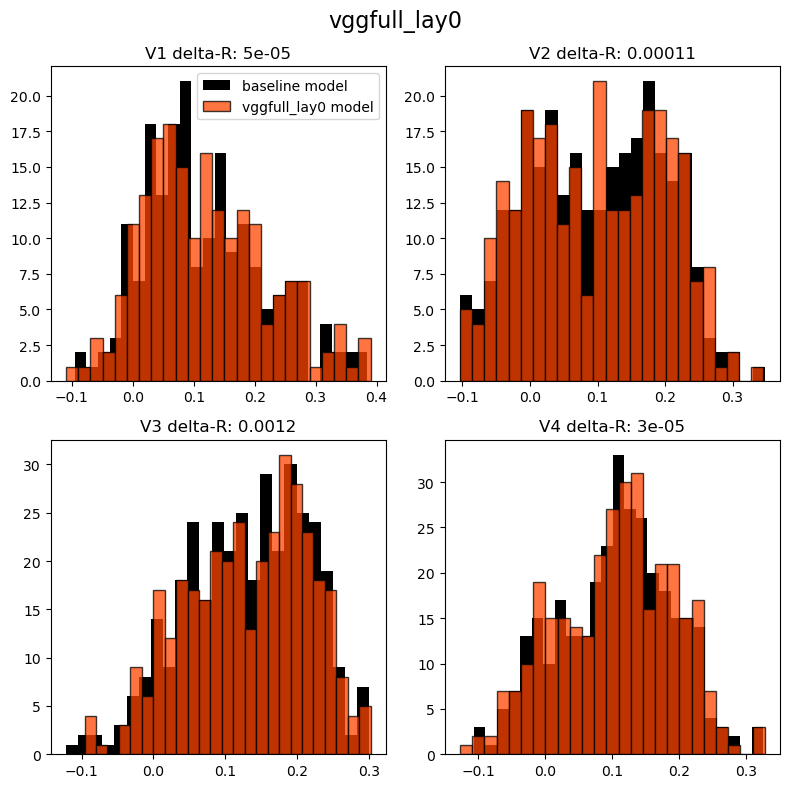

In [754]:
# Xbl = Xgabor_sub
# Xbl = X_pca
# Xbl = rms
# Xbl = Xconv3
start_idx = 0 # Set to 14 for dense layer only
n_layers = Xpred.shape[1]

print(f'Xpred has these dimensions: {Xpred.shape}')
        
# for layer in range(start_idx, Xpred.shape[1]):
for layer in range(start_idx, Xpred_mean.shape[1]):
    feat = f'{which_cnn}_lay{layer}'
    X_predfeat = Xpred_mean[:,layer].reshape(-1,1)
    X = np.hstack((Xbl, X_predfeat))
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)
    
    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                             ydict=ydict,
                             voxeldict=voxeldict,
                             X=X,
                             alpha=.1,
                             cv=5,
                             rois=rois,
                             X_alt=Xbl, # The baseline model
                             fit_icept=False,
                             save_outs=False,
                             regname=feat,
                             plot_hist=True,
                             alt_model_type="baseline model",
                             save_folder=f'unpred/{which_cnn}_sf5_dir9_loc_rat.6_pca',
                             X_str=f'{feat} model')


Xpred has these dimensions: (500, 1)
X has these dimensions: (500, 49)


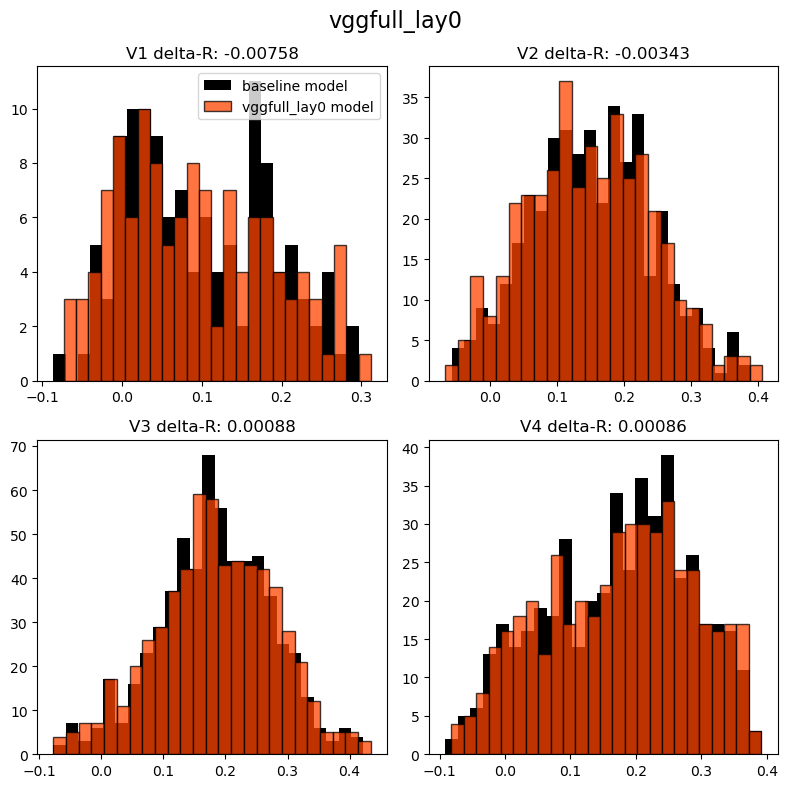

In [586]:
# Xbl = Xgabor_sub
# Xbl = X_pca
# Xbl = rms
# Xbl = Xconv3
start_idx = 0 # Set to 14 for dense layer only
n_layers = Xpred.shape[1]

print(f'Xpred has these dimensions: {Xpred.shape}')
        
for layer in range(start_idx, Xpred.shape[1]):
    feat = f'{which_cnn}_lay{layer}'
    X_predfeat = Xpred[:,layer].reshape(-1,1)
    X = np.hstack((Xbl, X_predfeat))
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)
    
    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                             ydict=ydict,
                             voxeldict=voxeldict,
                             X=X,
                             alpha=.1,
                             cv=5,
                             rois=rois,
                             X_alt=Xbl, # The baseline model
                             fit_icept=False,
                             save_outs=False,
                             regname=feat,
                             plot_hist=True,
                             alt_model_type="baseline model",
                             save_folder=f'unpred/{which_cnn}_sf5_dir9_loc_rat.6_pca',
                             X_str=f'{feat} model')


Xpred has these dimensions: (500, 17)
X has these dimensions: (500, 28)


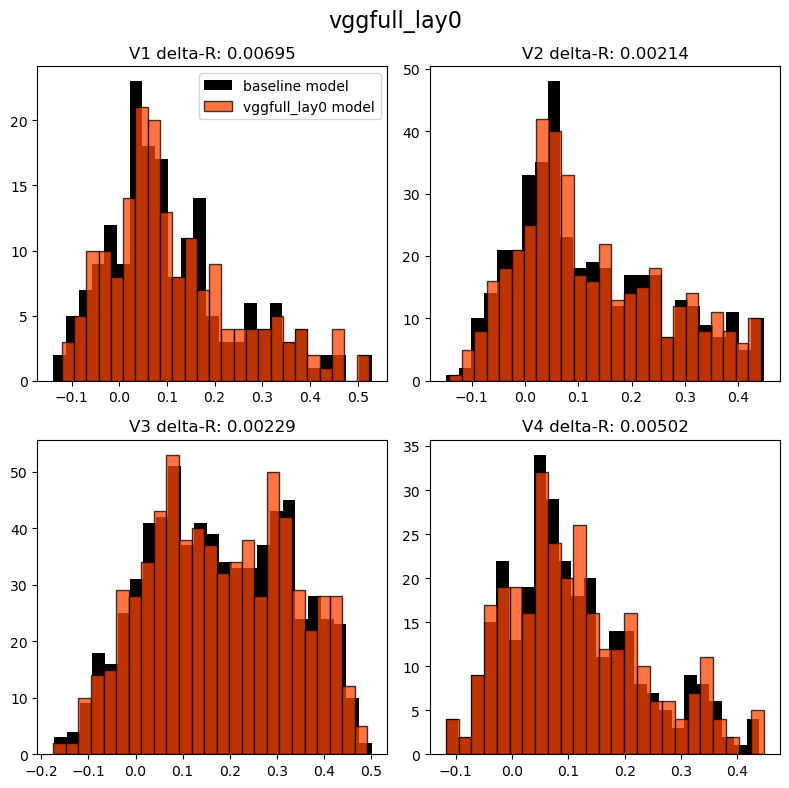

X has these dimensions: (500, 28)


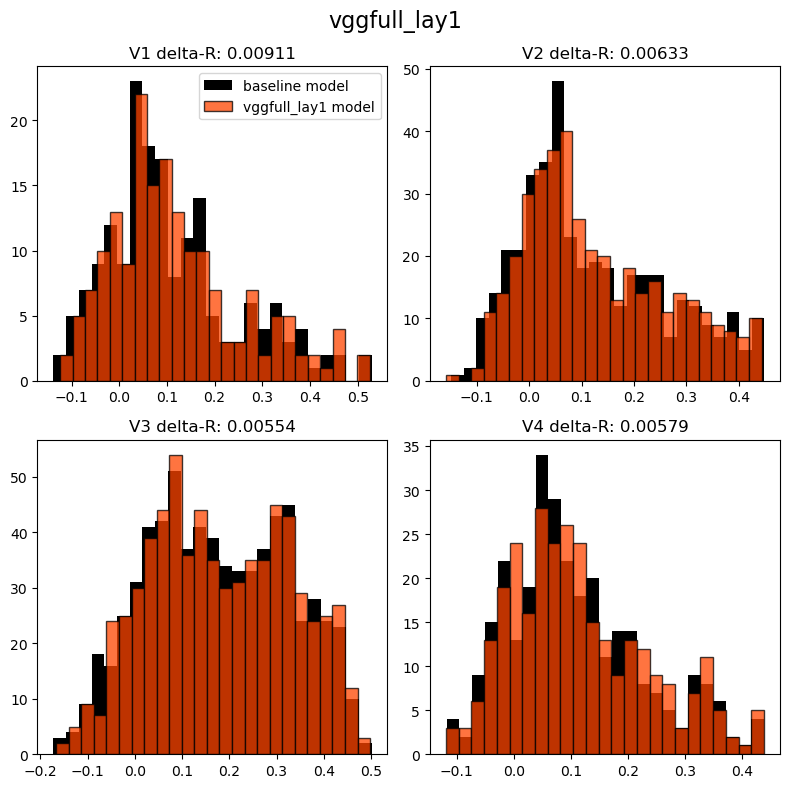

X has these dimensions: (500, 28)


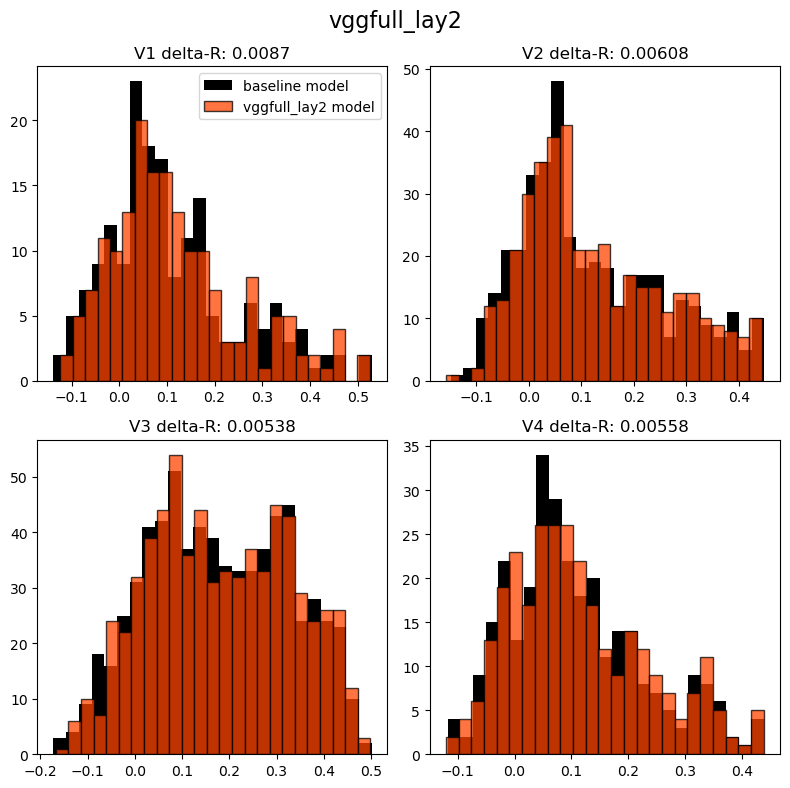

X has these dimensions: (500, 28)


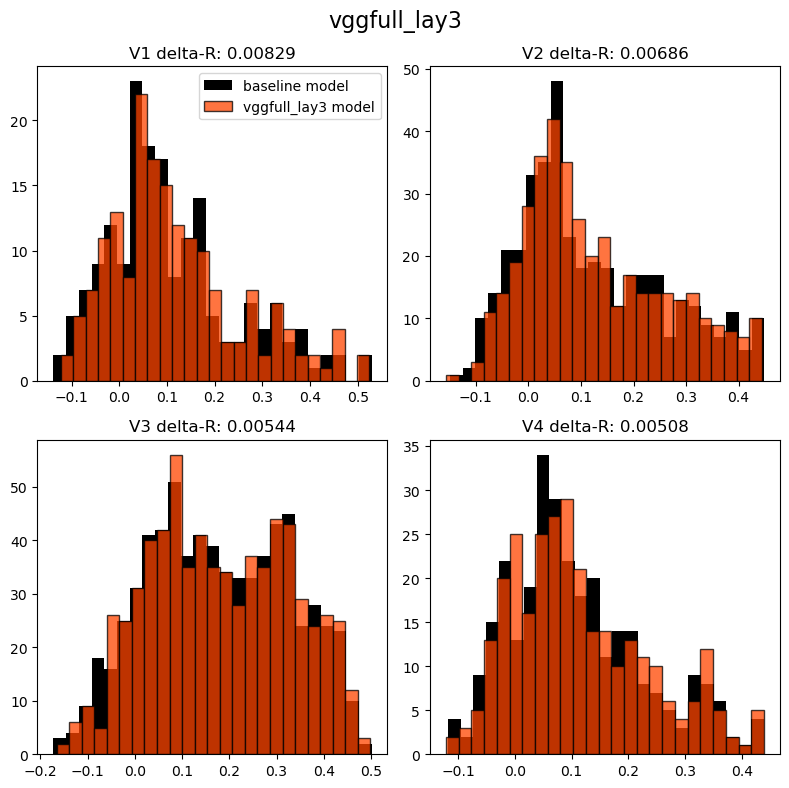

X has these dimensions: (500, 28)


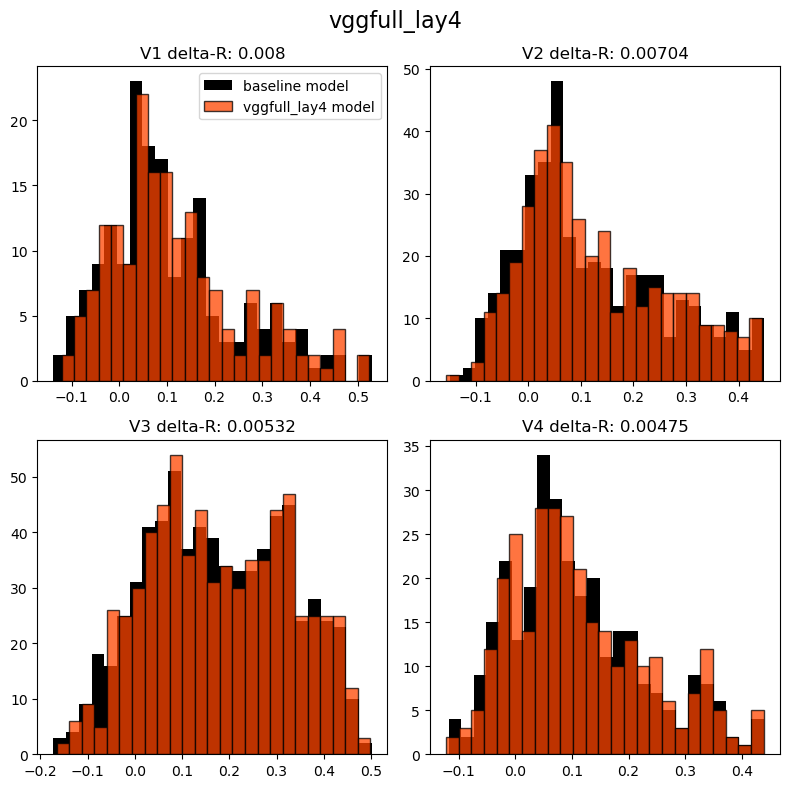

X has these dimensions: (500, 28)


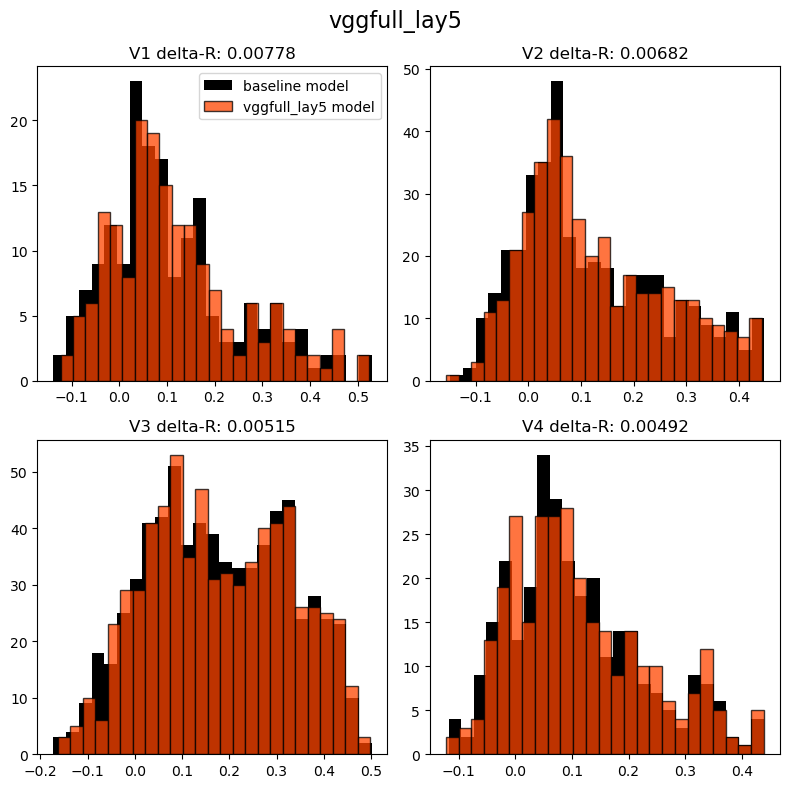

X has these dimensions: (500, 28)


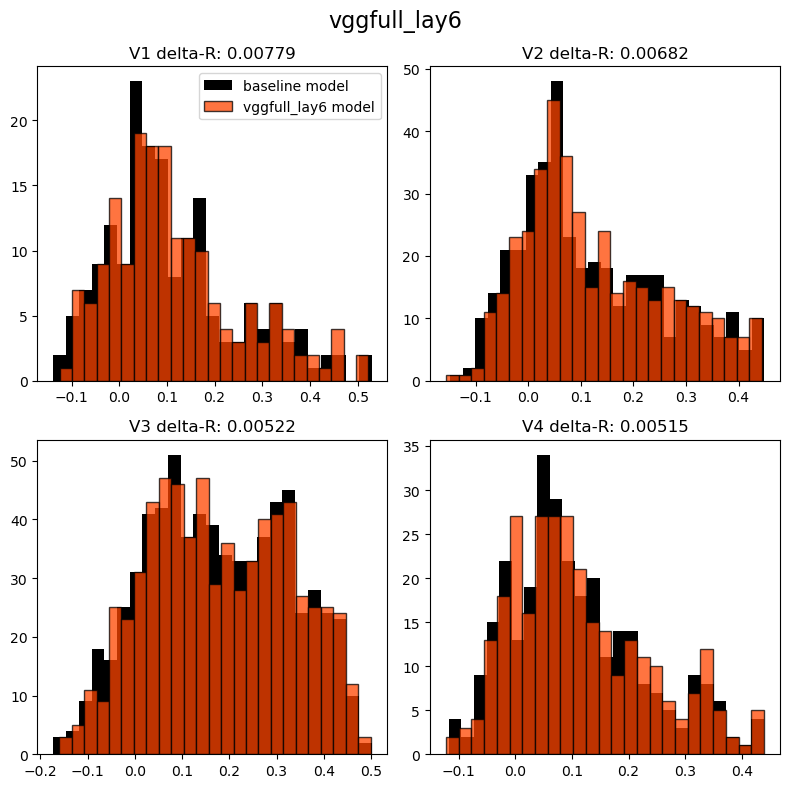

X has these dimensions: (500, 28)


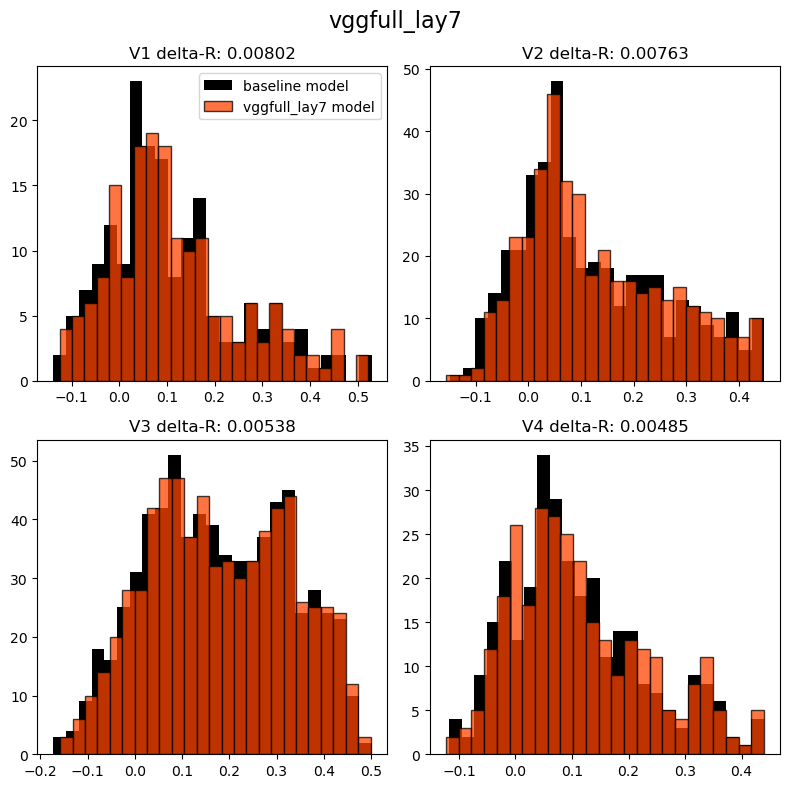

X has these dimensions: (500, 28)


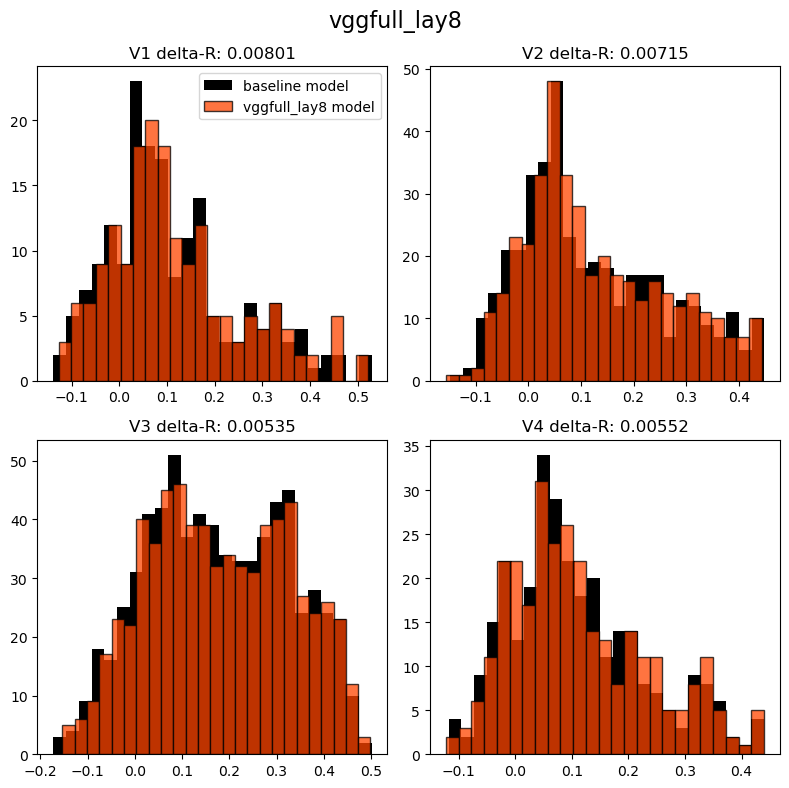

X has these dimensions: (500, 28)


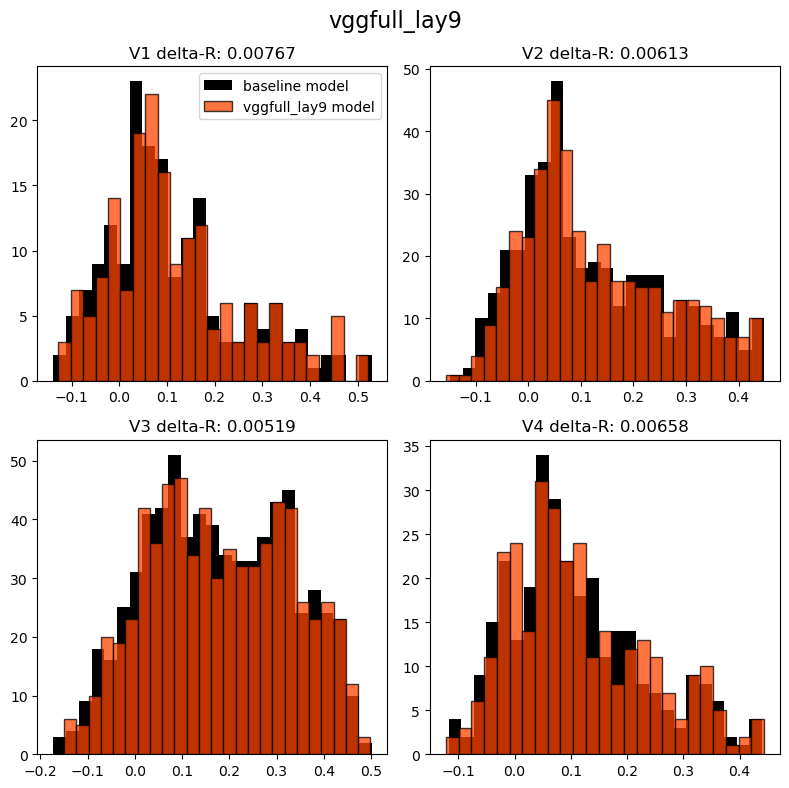

X has these dimensions: (500, 28)


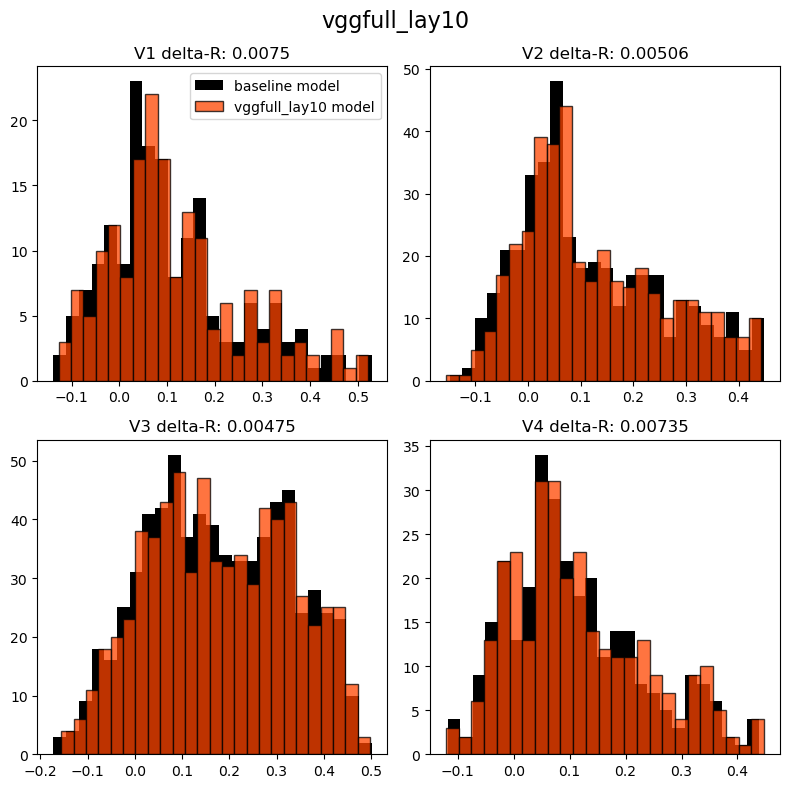

X has these dimensions: (500, 28)


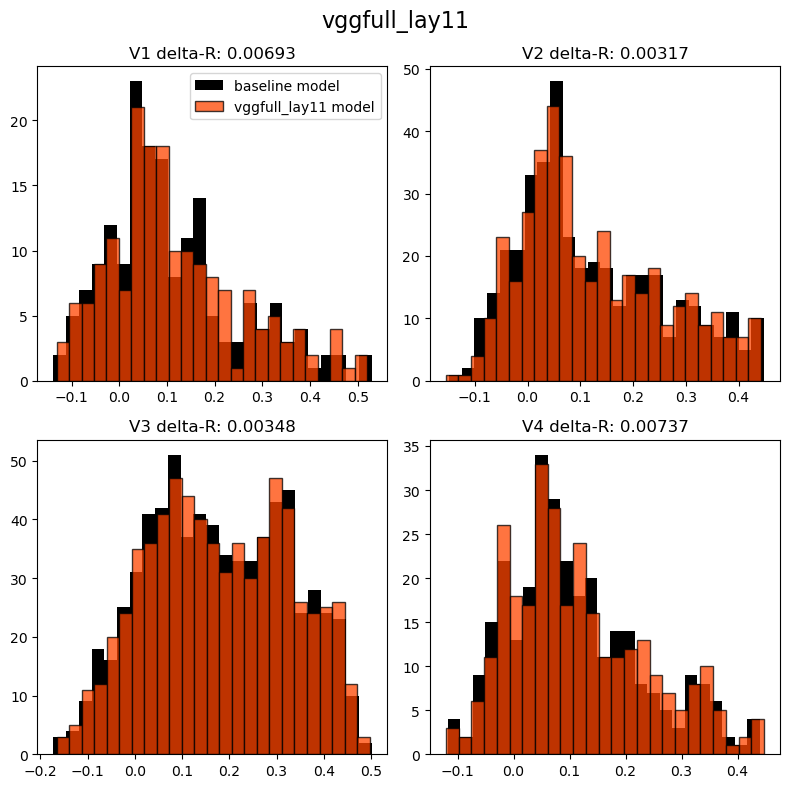

X has these dimensions: (500, 28)


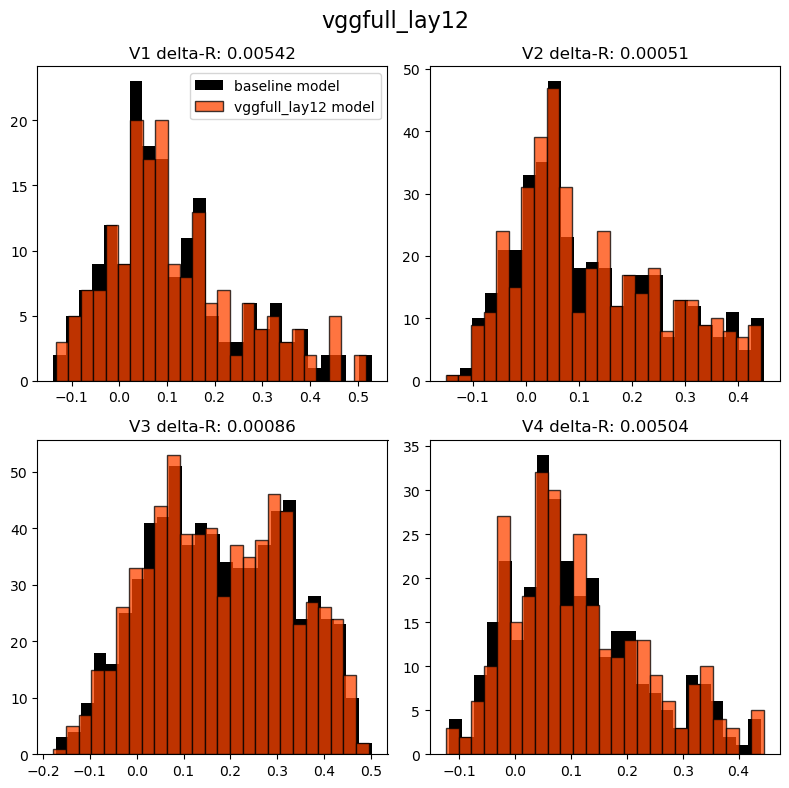

X has these dimensions: (500, 28)


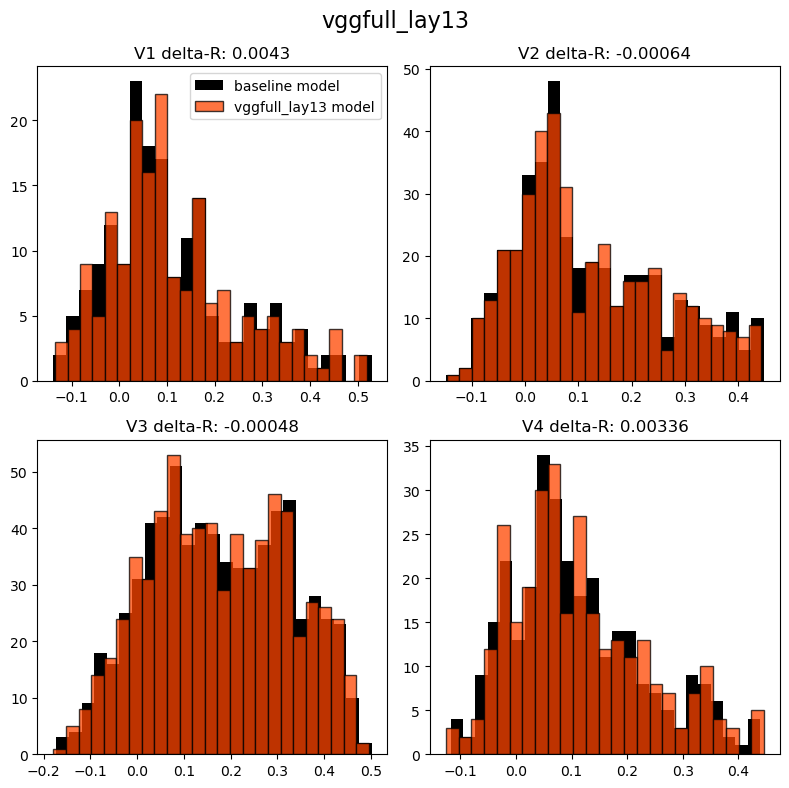

X has these dimensions: (500, 28)


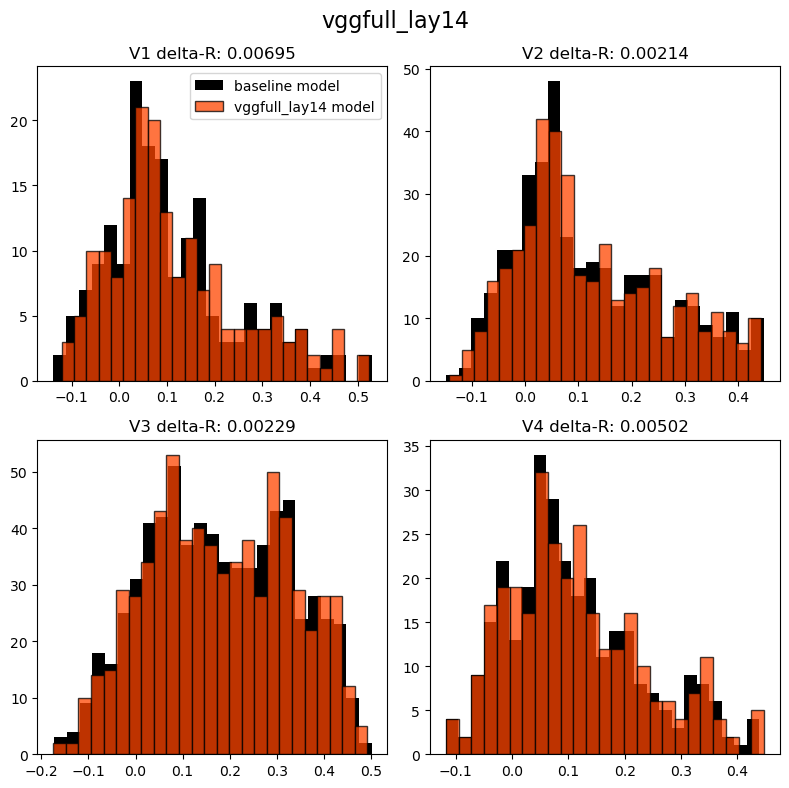

X has these dimensions: (500, 28)


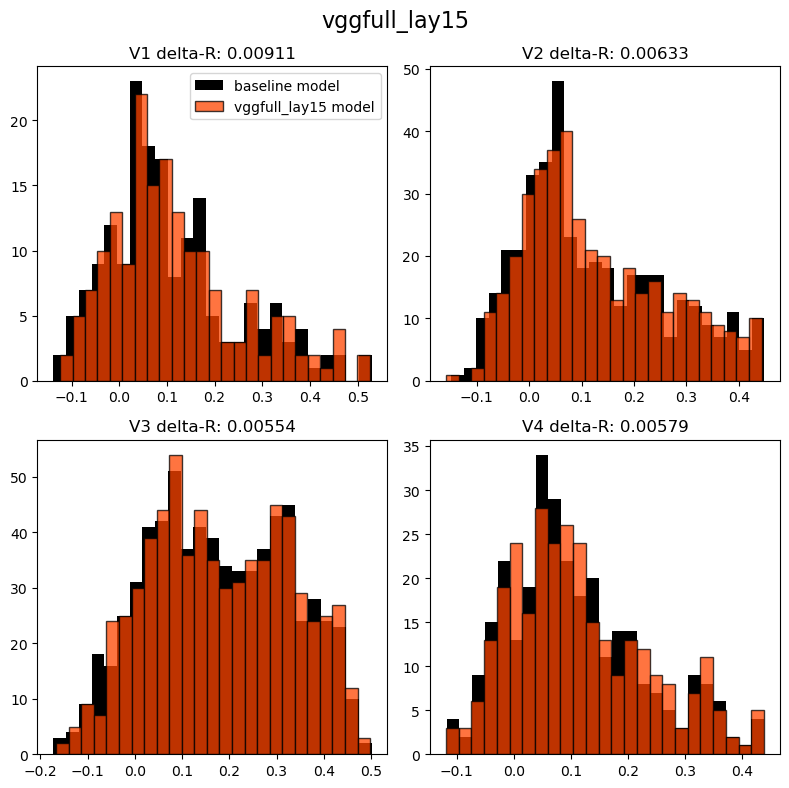

X has these dimensions: (500, 28)


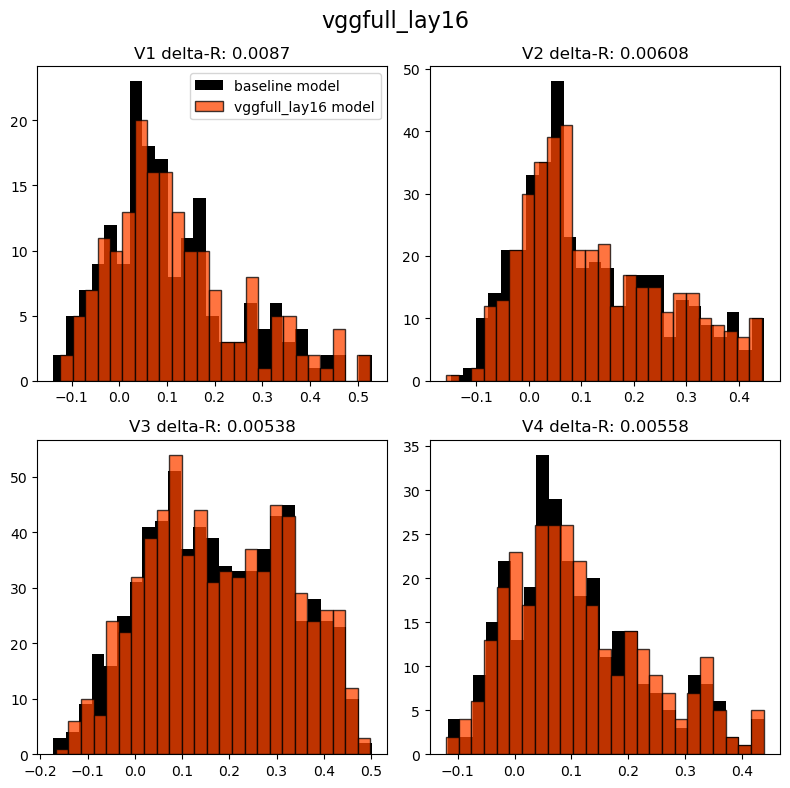

In [192]:
# Xbl = Xgabor_sub
# Xbl = X_pca
# Xbl = rms
# Xbl = Xconv3
start_idx = 0 # Set to 14 for dense layer only
n_layers = Xpred.shape[1]

print(f'Xpred has these dimensions: {Xpred.shape}')
        
for layer in range(start_idx, Xpred.shape[1]):
    feat = f'{which_cnn}_lay{layer}'
    X_predfeat = Xpred[:,layer].reshape(-1,1)
    X = np.hstack((Xbl, X_predfeat))
    print(f'X has these dimensions: {X.shape}')
    X_shuf = np.copy(X)
    np.random.shuffle(X_shuf)
    
    reg_df = NSP.analyse.analysis_chain_slim(subject=subject,
                             ydict=ydict,
                             voxeldict=voxeldict,
                             X=X,
                             alpha=.1,
                             cv=5,
                             rois=rois,
                             X_alt=Xbl, # The baseline model
                             fit_icept=False,
                             save_outs=False,
                             regname=feat,
                             plot_hist=True,
                             alt_model_type="baseline model",
                             save_folder=f'unpred/{which_cnn}_sf5_dir9_loc_rat.6_pca',
                             X_str=f'{feat} model')
